In [66]:
#importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
# from imblearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import shap

import warnings
warnings.filterwarnings('ignore')

In [40]:
#ler csv

#stats
stats_ger = pd.read_csv("rolling_avg/stats_avg_ger.csv")
stats_ita = pd.read_csv("rolling_avg/stats_avg_ita.csv")
stats_eng = pd.read_csv("rolling_avg/stats_avg_eng.csv")
stats_fra = pd.read_csv("rolling_avg/stats_avg_fra.csv")
stats_spa = pd.read_csv("rolling_avg/stats_avg_spa.csv")
stats_eur = pd.read_csv("rolling_avg/stats_avg_eur.csv")
stats_cup = pd.read_csv("rolling_avg/stats_avg_cup.csv")

#nets
nets_ger = pd.read_csv("rolling_avg/net_avg_ger.csv")
nets_ita = pd.read_csv("rolling_avg/net_avg_ita.csv")
nets_eng = pd.read_csv("rolling_avg/net_avg_eng.csv")
nets_fra = pd.read_csv("rolling_avg/net_avg_fra.csv")
nets_spa = pd.read_csv("rolling_avg/net_avg_spa.csv")
nets_eur = pd.read_csv("rolling_avg/net_avg_eur.csv")
nets_cup = pd.read_csv("rolling_avg/net_avg_cup.csv")

In [41]:
#junta stats com nets
ger = stats_ger.merge(nets_ger, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
ita = stats_ita.merge(nets_ita, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
eng = stats_eng.merge(nets_eng, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
fra = stats_fra.merge(nets_fra, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
spa = stats_spa.merge(nets_spa, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
eur = stats_eur.merge(nets_eur, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
cup = stats_cup.merge(nets_cup, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])

In [5]:
df = pd.concat([ger, ita, eng, fra, spa, eur, cup], ignore_index=True)

In [ ]:
df["month"] = df['date'].dt.month

In [166]:
# df["date"] = pd.to_datetime(df["date"])
df.groupby('tournament')['date'].max()

tournament
England                  September 9, 2017 at 4:00:00 PM GMT+2
European_Championship                2016-07-01 21:00:00-02:00
France                   September 9, 2017 at 8:00:00 PM GMT+2
Germany                  September 9, 2017 at 6:30:00 PM GMT+2
Italy                    September 9, 2017 at 6:00:00 PM GMT+2
Spain                    September 9, 2017 at 8:45:00 PM GMT+2
World_Cup                            2018-07-15 17:00:00-02:00
Name: date, dtype: object

In [ ]:
df["date"].dt.strftime('%Y-%m-%d')

In [101]:
df.groupby('tournament').count()

,matchID,team1_ID,team2_ID,date,winner,avg_gk_saves_T1,avg_red_card_T1,avg_yellow_card_T1,avg_assists_T1,avg_shots_T1,...,avg_max_eigenvector_centrality_T2,avg_avg_clustering_T2,avg_std_clustering_T2,avg_min_clustering_T2,avg_max_clustering_T2,avg_avg_shortest_path_T2,avg_mean_centroid_y_T2,avg_std_centroid_y_T2,avg_mean_centroid_x_T2,avg_std_centroid_x_T2
tournament,,,,,,,,,,,,,,,,,,,,,
England,231,231,231,231,231,231,231,231,231,231,...,231,231,231,231,231,231,231,231,231,231
European_Championship,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
France,230,230,230,230,230,230,230,230,230,230,...,230,230,230,230,230,230,230,230,230,230
Germany,179,179,179,179,179,179,179,179,179,179,...,179,179,179,179,179,179,179,179,179,179
Italy,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250
Spain,245,245,245,245,245,245,245,245,245,245,...,245,245,245,245,245,245,245,245,245,245
World_Cup,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [67]:
#Separando dados e target
X = df.drop(['winner', 'matchID', 'team1_ID', 'team2_ID', 'tournament', 'date'],axis=1)
y = df['winner'].astype('int')
col_names = X.columns
idx = df['matchID']

#Separando treino e teste
Xtrain, Xtest, y_train, y_test = train_test_split(X,
                                                  y.values,
                                                  stratify= y.values,
                                                  test_size=0.3,
                                                  random_state=42)

#Normalizando os dados
scaler = StandardScaler().fit(Xtrain)
train_sc = scaler.transform(Xtrain)
test_sc = scaler.transform(Xtest)

X_train = pd.DataFrame(train_sc, columns=col_names)
X_test = pd.DataFrame(test_sc, columns=col_names)

# Separado por tempo

In [8]:
#nets por tempo
nets_ger_t = pd.read_csv("rolling_avg/net_avg_ger_half.csv")
nets_ita_t = pd.read_csv("rolling_avg/net_avg_ita_half.csv")
nets_eng_t = pd.read_csv("rolling_avg/net_avg_eng_half.csv")
nets_fra_t = pd.read_csv("rolling_avg/net_avg_fra_half.csv")
nets_spa_t = pd.read_csv("rolling_avg/net_avg_spa_half.csv")
nets_eur_t = pd.read_csv("rolling_avg/net_avg_eur_half.csv")
nets_cup_t = pd.read_csv("rolling_avg/net_avg_cup_half.csv")

In [9]:
#junta stats com nets
ger_t = stats_ger.merge(nets_ger_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
ita_t = stats_ita.merge(nets_ita_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
eng_t = stats_eng.merge(nets_eng_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
fra_t = stats_fra.merge(nets_fra_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
spa_t = stats_spa.merge(nets_spa_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
eur_t = stats_eur.merge(nets_eur_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])
cup_t = stats_cup.merge(nets_cup_t, how='inner', on=['matchID','team1_ID', 'team2_ID', 'tournament', 'date', 'winner'])

In [10]:
df_t = pd.concat([ger_t, ita_t, eng_t, fra_t, spa_t, eur_t, cup_t], ignore_index=True)

In [11]:
df_t.shape

(1143, 134)

In [83]:
#Separando dados e target
X_t = df_t.drop(['winner', 'matchID', 'team1_ID', 'team2_ID', 'tournament', 'date'],axis=1)
y_t = df_t['winner'].astype('int')
col_names_t = X_t.columns
idx_t = df_t['matchID']

#Separando treino e teste
Xtrain_t, Xtest_t, y_train_t, y_test_t = train_test_split(X_t,
                                                  y_t.values,
                                                  stratify= y_t.values,
                                                  test_size=0.3,
                                                  random_state=42)

#Normalizando os dados
scaler = StandardScaler().fit(Xtrain_t)
train_sc_t = scaler.transform(Xtrain_t)
test_sc_t = scaler.transform(Xtest_t)

X_train_t = pd.DataFrame(train_sc_t, columns=col_names_t)
X_test_t = pd.DataFrame(test_sc_t, columns=col_names_t)

# Modelagem

## Setup

In [13]:
def feature_selection(data, threshold):   
    
    #removendo features com 0 de variância
    selector = VarianceThreshold()
    selector.fit_transform(data)
    df_var = data.loc[:, selector.get_support()]
    print(f"{len(data.columns) - len(df_var.columns)} colunas removidas com VarianceThreshold(0)")
    
    #removendo features com correlação alta
    corr = df_var.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= threshold:
                if columns[j]:
                    columns[j] = False
    selected_columns = df_var.columns[columns]
    df_corr = df_var[selected_columns]    
    print(f"{len(df_var.columns) - len(df_corr.columns)} colunas removidas com correlação > |{threshold}|")
    
    return df_corr

In [14]:
#Métricas de avaliação
def evaluation_metrics(clf,test_x, test_y, pred_y, ax_1, ax_2):
    accuracy = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
        
    plot_precision_recall_curve(clf, test_x, test_y, ax=ax_1)
    plot_roc_curve(clf, test_x, test_y, ax=ax_2)
    
    return accuracy, precision, recall, f1

In [ ]:
def logistic_regression(train_x, train_y):
    #Achando melhores hiperparâmetros com hyperopt para logistic regression
           
    #Define Parameter Space for Optimization
    space = {
        'C': hp.choice('C', [0.001, 0.01, 0.1, 1, 10, 100, 1000]),
        'penalty': hp.choice('penalty', ['l1', 'l2']),
        'max_iter': hp.quniform('max_iter', 100, 700, 100),
        'solver': hp.choice('solver', ['liblinear', 'saga']), #tirei 'lbfgs' e'sag' pq não funciona com l1
        'class_weight' : hp.choice('class_weight', ['balanced', None])
    }

    #Defining a Function to Minimize (Objective Function)
    def hyperparameter_tuning(params):
        clf = LogisticRegression(**params, random_state=42, n_jobs=-1)
        f1 = cross_val_score(clf, train_x, train_y, cv=5, scoring='accuracy', error_score='raise').mean()
        
        return {"loss": -f1, "status": STATUS_OK}

    # Fine Tune the Model
    trials = Trials()

    best = fmin(
        fn=hyperparameter_tuning,
        space = space, 
        algo=tpe.suggest, 
        max_evals=10, 
        trials=trials
    )

    print("Logistic Regression - Best: {}".format(best))
    
    logi = LogisticRegression(
        C=[0.001, 0.01, 0.1, 1, 10, 100, 1000][best['C']],
        penalty=['l1', 'l2'][best['penalty']], 
        solver=['liblinear', 'saga'][best['solver']], 
        max_iter=best['max_iter'], 
        class_weight=['balanced', None][best['class_weight']])

    return logi

In [16]:
def random_forest(train_x, train_y):
    #Achando melhores hiperparâmetros com hyperopt para Random Forest

    #Define Parameter Space for Optimization
    space = {
        "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500]),
        "max_depth": hp.quniform("max_depth", 2, 24, 2),
        "max_features": hp.choice("max_features", ['auto', 'sqrt', 'log2']),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
        "min_samples_leaf":hp.choice("min_samples_leaf", [1, 2, 3, 4, 5]),
        "min_samples_split":hp.choice("min_samples_split", [2, 3, 4, 5, 6]),
        "class_weight": hp.choice("class_weight", ['balanced', 'balanced_subsample', None]),
        "bootstrap": hp.choice("bootstrap", [True, False])
    }

    #Defining a Function to Minimize (Objective Function)
    def hyperparameter_tuning(params):
        model = RandomForestClassifier(**params, n_jobs=-1)
        f1 = cross_val_score(model, train_x, train_y, cv = 10, scoring='accuracy', error_score='raise').mean()
        
        return {"loss": -f1, "status": STATUS_OK}

    # Fine Tune the Model
    trials = Trials()

    best = fmin(
        fn=hyperparameter_tuning,
        space = space, 
        algo=tpe.suggest, 
        max_evals=20, 
        trials=trials
    )
    print(" Random Forest - Best: {}".format(best))


    rf = RandomForestClassifier(
        n_estimators=[100, 200, 300, 400,500][3],
        max_depth=best['max_depth'],
        max_features=['auto', 'sqrt', 'log2'][best['max_features']],
        criterion=["gini", "entropy"][best['criterion']],
        min_samples_leaf=[1, 2, 3, 4, 5][best['min_samples_leaf']],
        min_samples_split=[2, 3, 4, 5, 6][best['min_samples_split']],
        random_state=42,
        class_weight=['balanced', 'balanced_subsample', None][best['class_weight']],
        bootstrap=[True, False][best['bootstrap']],
        n_jobs = -1)

    return rf

In [17]:
def xgboosting(train_x, train_y):
    #Achando melhores hiperparâmetros com hyperopt para XGBoosting

    #Define Parameter Space for Optimization
    space = {
    'max_depth' : hp.choice('max_depth', range(5, 15, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(50, 400, 10)),
    'gamma' : hp.quniform('gamma', 0, 0.30, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'scale_pos_weight' : hp.choice('scale_pos_weight', range(4, 25, 1)),
    }

    #Defining a Function to Minimize (Objective Function)
    def hyperparameter_tuning(params):
        clf = XGBClassifier(**params, random_state=42, verbosity=0, objective= 'binary:logistic', n_jobs=-1)
        f1 = cross_val_score(clf, train_x, train_y, cv=10, scoring='accuracy').mean()
        
        return {"loss": -f1, "status": STATUS_OK}

    # Fine Tune the Model
    trials = Trials()

    best = fmin(
        fn=hyperparameter_tuning,
        space = space, 
        algo=tpe.suggest, 
        max_evals=20, 
        trials=trials
    )
    print("XGBoosting - Best: {}".format(best))

    xgb = XGBClassifier(
        learning_rate=best['learning_rate'],
        n_estimators=range(50, 400, 10)[best['n_estimators']],
        max_depth=range(5, 15, 1)[best['max_depth']],
        min_child_weight=best['min_child_weight'],
        gamma=best['gamma'],
        subsample=best['subsample'],
        colsample_bytree=best['colsample_bytree'],
        objective= 'binary:logistic',
        scale_pos_weight=range(4, 25, 1)[best['scale_pos_weight']])

    return xgb

In [76]:
def naive_bayes(train_x, train_y):

    #Achando melhores hiperparâmetros com hyperopt para Naive Bayes

    #Define Parameter Space for Optimization
    space = {
        'var_smoothing': np.logspace(0,-9, num=100),
    }

    #Defining a Function to Minimize (Objective Function)
    def hyperparameter_tuning(params):
        clf = GaussianNB(**params, verbosity=0, n_jobs=-1)
        f1 = cross_val_score(clf, train_x, train_y, cv=10, scoring='accuracy').mean()
        
        return {"loss": -f1, "status": STATUS_OK}

    # Fine Tune the Model
    trials = Trials()

    best = fmin(
        fn=hyperparameter_tuning,
        space = space, 
        algo=tpe.suggest, 
        max_evals=20, 
        trials=trials
    )
    print("GaussianNB - Best: {}".format(best))

    nb = GaussianNB(
        var_smoothing = best['var_smoothing'])

    return nb

In [79]:
def testa_modelos(train_x, train_y, test_x, test_y):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

    logi = logistic_regression(train_x, train_y)
    rf = random_forest(train_x, train_y)
    xgb = xgboosting(train_x, train_y)
    nb = GaussianNB()

    for clf, name in [(logi, 'LogisticRegression'),
                      (rf, 'RandomForest'),
                      (xgb, 'XGBClassifier'),
                      (nb, 'GaussianNB')]:
        
        cv = cross_val_score(clf,train_x,train_y, cv = 10 , scoring='accuracy')
        CrossValMean = cv.mean()
        CrossValSTD = cv.std()
        print("")
        print(f"{name}:")
        print(f"CrossVal (mean/std): {100*CrossValMean:.3f}% / {100*CrossValSTD:.3f}%")
        
        clf.fit(train_x, train_y)
        y_pred = clf.predict(test_x)

        accuracy, precision, recall, f1 = evaluation_metrics(clf, test_x, test_y, y_pred, ax1, ax2)
        print(f"accuracy: {100*accuracy:.2f}% | precision: {100*precision:.2f}% | recall: {100*recall:.2f}% | f1: {100*f1:.2f}%")
    
    ax1.legend(loc="right")
    ax1.set_title('Precision-Recall curve')
    
    ax2.legend(loc="right")
    ax2.set_title('ROC AUC curve')

## Por jogo inteiro

100%|██████████| 10/10 [00:27<00:00,  2.79s/trial, best loss: -0.7640591727658059]
Logistic Regression - Best: {'C': 3, 'class_weight': 1, 'max_iter': 300.0, 'penalty': 0, 'solver': 1}
100%|██████████| 20/20 [02:46<00:00,  8.32s/trial, best loss: -0.7262500000000001]
 Random Forest - Best: {'bootstrap': 1, 'class_weight': 2, 'criterion': 1, 'max_depth': 8.0, 'max_features': 1, 'min_samples_leaf': 0, 'min_samples_split': 3, 'n_estimators': 2}
100%|██████████| 20/20 [01:36<00:00,  4.84s/trial, best loss: -0.7]   
XGBoosting - Best: {'colsample_bytree': 0.64, 'gamma': 0.06, 'learning_rate': 0.16, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 30, 'scale_pos_weight': 13, 'subsample': 0.8500000000000001}

LogisticRegression:
CrossVal (mean/std): 69.625% / 5.450%
accuracy: 66.76% | precision: 70.74% | recall: 77.51% | f1: 73.97%

RandomForest:
CrossVal (mean/std): 72.125% / 3.538%
accuracy: 65.89% | precision: 67.69% | recall: 84.21% | f1: 75.05%

XGBClassifier:
CrossVal (mean/std)

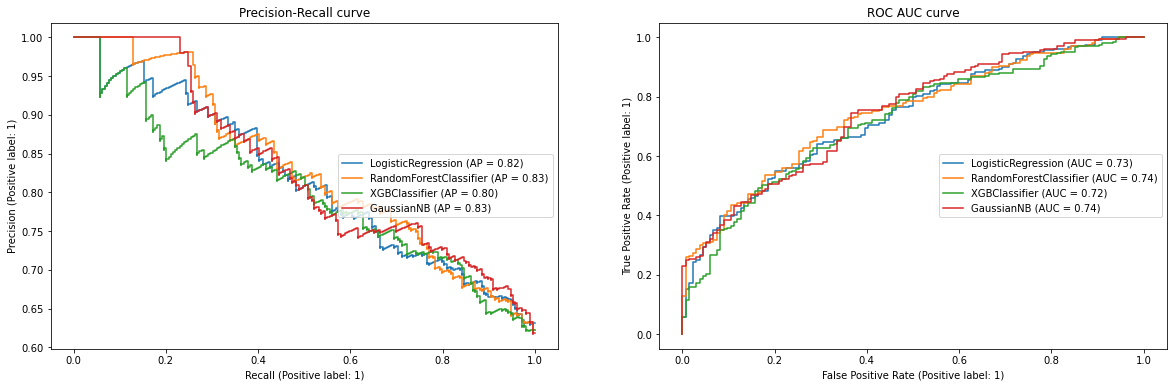

In [80]:
testa_modelos(X_train, y_train, X_test, y_test)

In [ ]:
sorted_idx = rf.feature_importances_.argsort()[:-11:-1]
plt.barh(df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

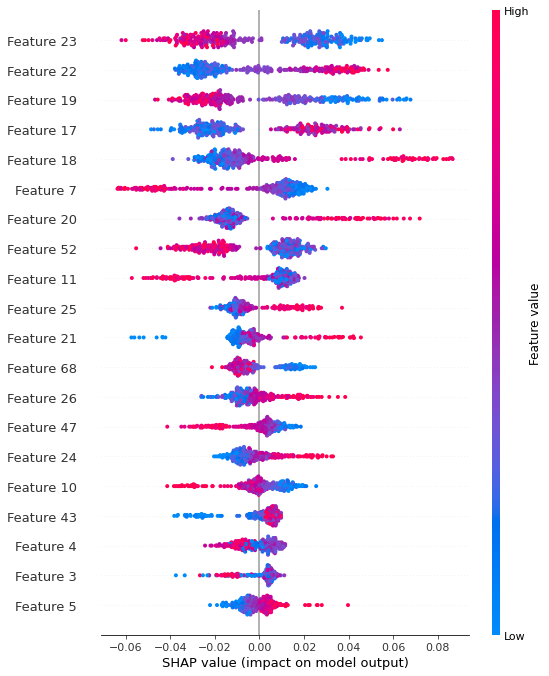

In [110]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[0], X_test, plot_type='dot')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

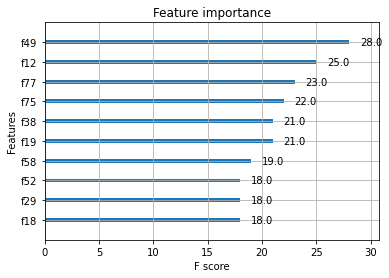

In [112]:
#Feature importance do modelo escolhido
plot_importance(clf, max_num_features = 10)

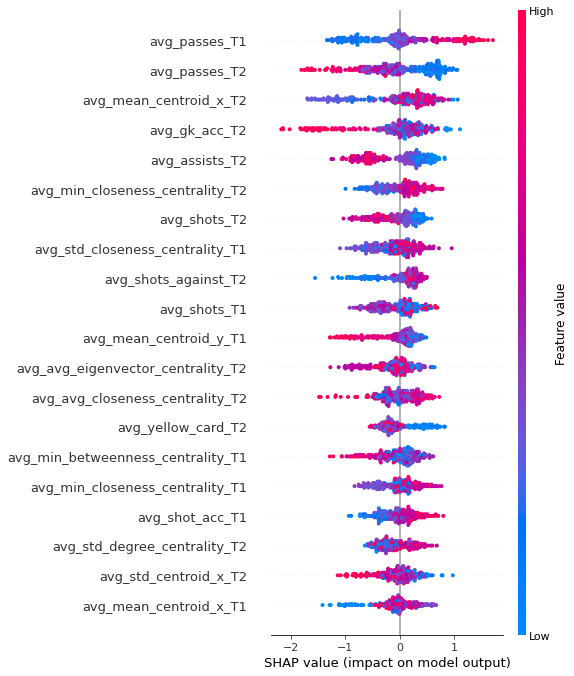

In [75]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

0 colunas removidas com VarianceThreshold(0)
35 colunas removidas com correlação > |0.8|
100%|██████████| 10/10 [00:14<00:00,  1.48s/trial, best loss: -0.7768541596320201]
Logistic Regression - Best: {'C': 2, 'class_weight': 1, 'max_iter': 200.0, 'penalty': 0, 'solver': 1}
100%|██████████| 20/20 [01:22<00:00,  4.15s/trial, best loss: -0.7262500000000001]
 Random Forest - Best: {'bootstrap': 0, 'class_weight': 0, 'criterion': 0, 'max_depth': 16.0, 'max_features': 0, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 2}
100%|██████████| 20/20 [00:37<00:00,  1.90s/trial, best loss: -0.68625]          
XGBoosting - Best: {'colsample_bytree': 0.25, 'gamma': 0.14, 'learning_rate': 0.14, 'max_depth': 7, 'min_child_weight': 1.0, 'n_estimators': 17, 'scale_pos_weight': 9, 'subsample': 0.65}

LogisticRegression:
CrossVal (mean/std): 69.500% / 5.339%
accuracy: 68.80% | precision: 70.24% | recall: 84.69% | f1: 76.79%

RandomForest:
CrossVal (mean/std): 72.375% / 3.281%
accuracy: 66.76%

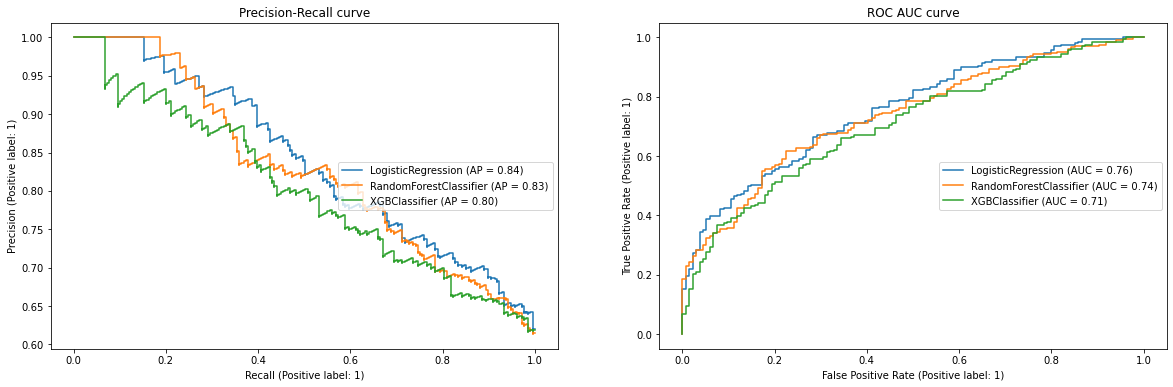

In [48]:
df_sel = feature_selection(X, 0.8)
#Separando dados e target
col_names = df_sel.columns
#Normalizando os dados
XScaled_sel = StandardScaler().fit_transform(df_sel)
#Separando treino e teste
X_train_sel, X_test_sel, y_train, y_test = train_test_split(XScaled_sel,
                                                    y.values,
                                                    stratify= y.values,
                                                    test_size=0.3,
                                                    random_state=42)
# train_df = pd.DataFrame(X_train, columns=col_names)
# test_df = pd.DataFrame(X_test, columns=col_names)
testa_modelos(X_train_sel, y_train, X_test_sel, y_test)


100%|██████████| 10/10 [00:00<00:00, 26.07trial/s, best loss: -0.7598295880070609]
Logistic Regression - Best: {'C': 2, 'class_weight': 1, 'max_iter': 200.0, 'penalty': 1, 'solver': 1}
100%|██████████| 20/20 [01:25<00:00,  4.29s/trial, best loss: -0.7025]
 Random Forest - Best: {'bootstrap': 1, 'class_weight': 2, 'criterion': 1, 'max_depth': 6.0, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}
100%|██████████| 20/20 [00:26<00:00,  1.33s/trial, best loss: -0.67375]
XGBoosting - Best: {'colsample_bytree': 0.27, 'gamma': 0.07, 'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 4.0, 'n_estimators': 14, 'scale_pos_weight': 11, 'subsample': 1.0}

LogisticRegression:
CrossVal (mean/std): 69.000% / 4.835%
accuracy: 66.76% | precision: 69.87% | recall: 79.90% | f1: 74.55%

RandomForest:
CrossVal (mean/std): 69.000% / 4.500%
accuracy: 65.89% | precision: 66.67% | recall: 88.04% | f1: 75.88%

XGBClassifier:
CrossVal (mean/std): 66.750% / 4.975%
accuracy

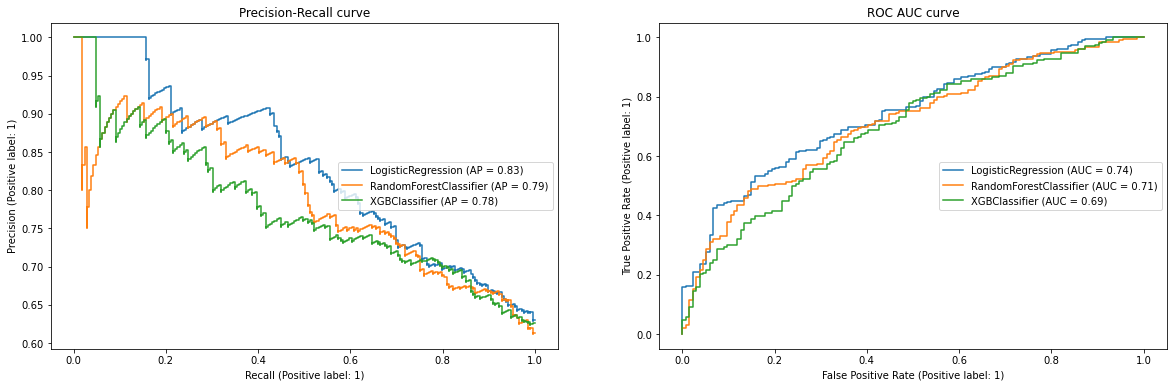

In [65]:
#PCA
testa_modelos(X_train_pca, y_train, X_test_pca, y_test)

## Por tempo

100%|██████████| 10/10 [00:20<00:00,  2.09s/trial, best loss: -0.7446113460432475]
Logistic Regression - Best: {'C': 2, 'class_weight': 1, 'max_iter': 500.0, 'penalty': 1, 'solver': 1}
100%|██████████| 20/20 [01:54<00:00,  5.70s/trial, best loss: -0.7]              
 Random Forest - Best: {'bootstrap': 1, 'class_weight': 0, 'criterion': 0, 'max_depth': 14.0, 'max_features': 1, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 4}
100%|██████████| 20/20 [01:27<00:00,  4.39s/trial, best loss: -0.6812499999999999]
XGBoosting - Best: {'colsample_bytree': 0.44, 'gamma': 0.29, 'learning_rate': 0.42, 'max_depth': 8, 'min_child_weight': 7.0, 'n_estimators': 32, 'scale_pos_weight': 2, 'subsample': 0.9500000000000001}

LogisticRegression:
CrossVal (mean/std): 66.875% / 5.281%
accuracy: 66.76% | precision: 71.69% | recall: 75.12% | f1: 73.36%

RandomForest:
CrossVal (mean/std): 70.625% / 5.311%
accuracy: 70.26% | precision: 71.49% | recall: 85.17% | f1: 77.73%

XGBClassifier:
CrossVal

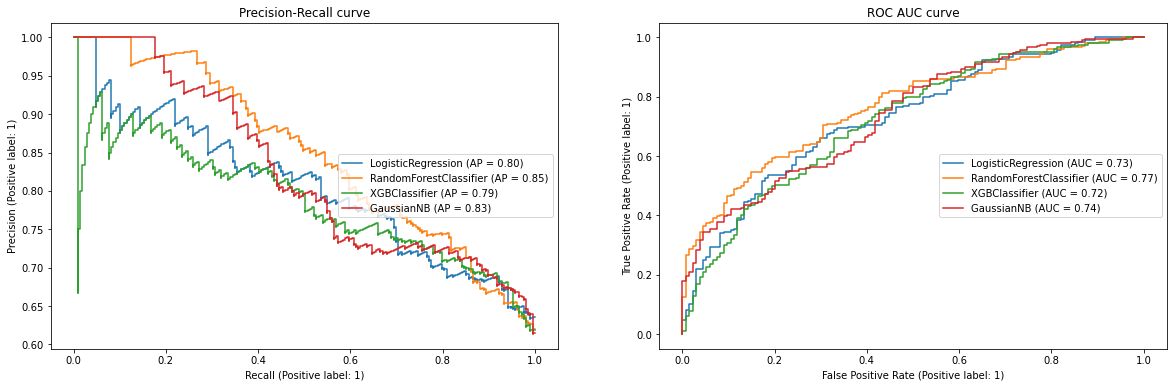

In [84]:
testa_modelos(X_train_t, y_train_t, X_test_t, y_test_t)

Text(0.5, 0, 'Random Forest Feature Importance')

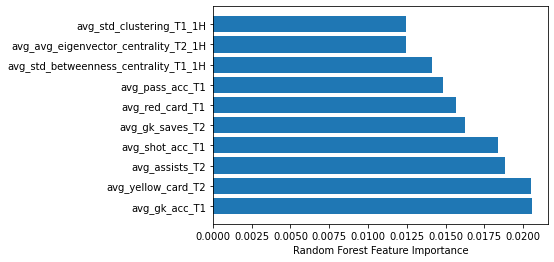

In [85]:
rf = RandomForestClassifier(
        n_estimators=[100, 200, 300, 400,500][4],
        max_depth=14,
        max_features=['auto', 'sqrt', 'log2'][1],
        criterion=["gini", "entropy"][0],
        min_samples_leaf=[1, 2, 3, 4, 5][0],
        min_samples_split=[2, 3, 4, 5, 6][0],
        random_state=42,
        class_weight=['balanced', 'balanced_subsample', None][0],
        bootstrap=[True, False][1],
        n_jobs = -1)
rf.fit(X_train_t, y_train_t)

sorted_idx = rf.feature_importances_.argsort()[:-11:-1]
plt.barh(df_t.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

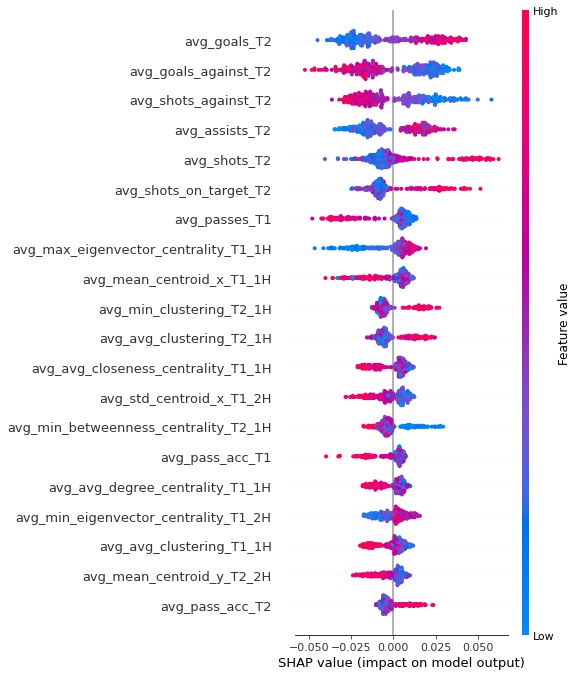

In [86]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_df_t)

shap.summary_plot(shap_values[0], test_df_t, plot_type='dot')

In [ ]:
df_sel = feature_selection(X_t, 0.8)
testa_modelos(X_train_t, y_train_t, X_test_t, y_test_t)

0 colunas removidas com VarianceThreshold(0)
64 colunas removidas com correlação > |0.8|
100%|██████████| 10/10 [00:01<00:00,  7.72trial/s, best loss: -0.7736767074150251]
Logistic Regression - Best: {'C': 2, 'class_weight': 1, 'max_iter': 100.0, 'penalty': 0, 'solver': 1}
100%|██████████| 20/20 [01:29<00:00,  4.49s/trial, best loss: -0.72625]
 Random Forest - Best: {'bootstrap': 1, 'class_weight': 0, 'criterion': 1, 'max_depth': 20.0, 'max_features': 0, 'min_samples_leaf': 0, 'min_samples_split': 3, 'n_estimators': 3}
100%|██████████| 20/20 [00:37<00:00,  1.89s/trial, best loss: -0.6849999999999999]
XGBoosting - Best: {'colsample_bytree': 0.53, 'gamma': 0.18, 'learning_rate': 0.09, 'max_depth': 8, 'min_child_weight': 3.0, 'n_estimators': 31, 'scale_pos_weight': 2, 'subsample': 0.25}

LogisticRegression:
CrossVal (mean/std): 67.750% / 6.245%
accuracy: 69.39% | precision: 70.63% | recall: 85.17% | f1: 77.22%

RandomForest:
CrossVal (mean/std): 71.750% / 4.373%
accuracy: 67.93% | precisi

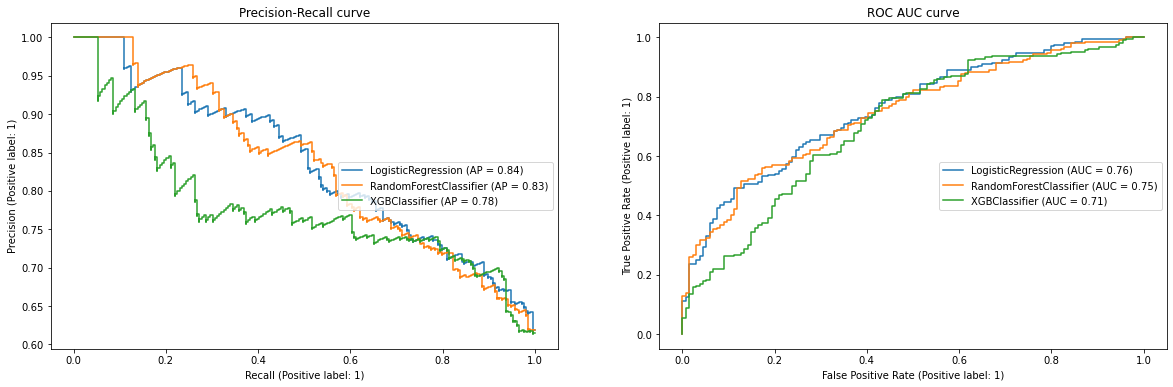

In [51]:
df_t_sel = feature_selection(X_t, 0.8)
#Separando dados e target
col_names = df_t_sel.columns
#Normalizando os dados
XScaled_t_sel = StandardScaler().fit_transform(df_t_sel)
#Separando treino e teste
X_train_t_sel, X_test_t_sel, y_train_t, y_test_t = train_test_split(XScaled_t_sel,
                                                    y_t.values,
                                                    stratify= y_t.values,
                                                    test_size=0.3,
                                                    random_state=42)
# train_df = pd.DataFrame(X_train, columns=col_names)
# test_df = pd.DataFrame(X_test, columns=col_names)
testa_modelos(X_train_t_sel, y_train_t, X_test_t_sel, y_test_t)


100%|██████████| 10/10 [00:00<00:00, 13.08trial/s, best loss: -0.7749142682144226]
Logistic Regression - Best: {'C': 0, 'class_weight': 1, 'max_iter': 700.0, 'penalty': 1, 'solver': 1}
100%|██████████| 20/20 [01:25<00:00,  4.28s/trial, best loss: -0.695]             
 Random Forest - Best: {'bootstrap': 0, 'class_weight': 0, 'criterion': 0, 'max_depth': 10.0, 'max_features': 2, 'min_samples_leaf': 0, 'min_samples_split': 0, 'n_estimators': 4}
100%|██████████| 20/20 [00:38<00:00,  1.95s/trial, best loss: -0.6650000000000001]
XGBoosting - Best: {'colsample_bytree': 0.42, 'gamma': 0.06, 'learning_rate': 0.26, 'max_depth': 0, 'min_child_weight': 8.0, 'n_estimators': 26, 'scale_pos_weight': 4, 'subsample': 0.4}

LogisticRegression:
CrossVal (mean/std): 68.375% / 4.543%
accuracy: 68.80% | precision: 69.77% | recall: 86.12% | f1: 77.09%

RandomForest:
CrossVal (mean/std): 68.375% / 5.094%
accuracy: 67.35% | precision: 68.03% | recall: 87.56% | f1: 76.57%

XGBClassifier:
CrossVal (mean/std): 6

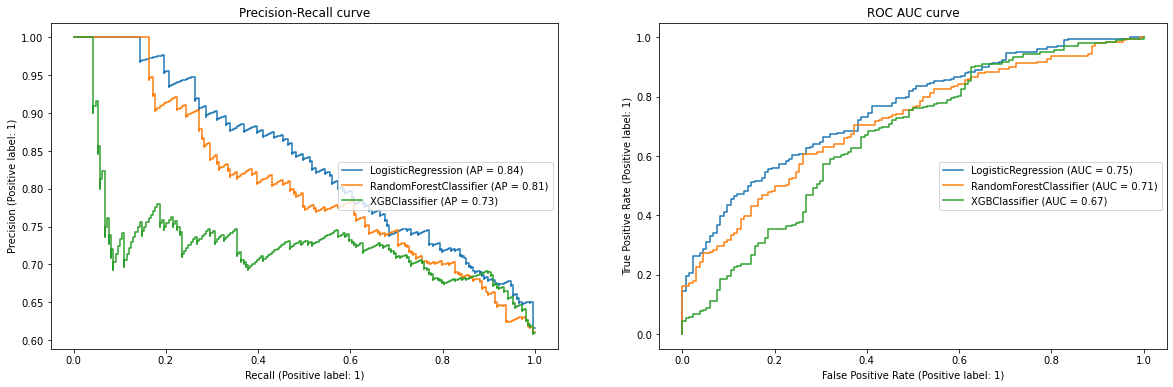

In [63]:
#PCA
testa_modelos(X_train_pca, y_train_t, X_test_pca, y_test_t)

## Treinar por campeonatos

In [45]:
def split_dataset(df):
    #Separando dados e target
    X = df.drop(['winner', 'matchID', 'team1_ID', 'team2_ID', 'tournament', 'date'],axis=1)
    y = df['winner'] 
    col_names = X.columns
    idx = df['matchID']

    #Normalizando os dados
    XScaled = StandardScaler().fit_transform(X)

    #Separando treino e teste
    X_train, X_test, y_train, y_test = train_test_split(XScaled,
                                                        y.values,
                                                        stratify= y.values,
                                                        test_size=0.3,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [37]:
def testa_modelos_times(df_ger, df_eng, df_ita, df_fra, df_spa):
    
    cvmean = []
    cvstd = []
    acc = []
    auc = []

    for df in [df_ger, df_eng, df_ita, df_fra, df_spa]:
        
        train_x, test_x, train_y, test_y = split_dataset(df)

        logi = logistic_regression(train_x, train_y)
        rf = random_forest(train_x, train_y)
        xgb = xgboosting(train_x, train_y)

        for clf, name in [(logi, 'LogisticRegression'),
                        (rf, 'RandomForest'),
                        (xgb, 'XGBClassifier')]:
            
            cv = cross_val_score(clf,train_x,train_y, cv = 10 , scoring='accuracy')
            cvmean.append(cv.mean())
            cvstd.append(cv.std())

            clf.fit(train_x, train_y)
            y_pred = clf.predict(test_x)

            acc.append(accuracy_score(test_y, y_pred))
            auc.append(roc_auc_score(test_y, clf.predict_proba(test_x)[:, 1]))

    print('GER:')
    print(f"Logistic Regression: Cross validation mean/std: {100*cvmean[0]:.3f}% / {100*cvstd[0]:.3f}% | acc: {100*acc[0]:.3f}% | auc: {100*auc[0]:.3f}%")
    print(f"RandomForest: Cross validation mean/std: {100*cvmean[1]:.3f}% / {100*cvstd[1]:.3f}% | acc: {100*acc[1]:.3f}% | auc: {100*auc[1]:.3f}%")
    print(f"XGBoosting: Cross validation mean/std: {100*cvmean[2]:.3f}% / {100*cvstd[2]:.3f}% | acc: {100*acc[2]:.3f}% | auc: {100*auc[2]:.3f}%")
    print('ENG:')
    print(f"Logistic Regression: Cross validation mean/std: {100*cvmean[3]:.3f}% / {100*cvstd[3]:.3f}% | acc: {100*acc[3]:.3f}% | auc: {100*auc[3]:.3f}%")
    print(f"RandomForest: Cross validation mean/std: {100*cvmean[4]:.3f}% / {100*cvstd[4]:.3f}% | acc: {100*acc[4]:.3f}% | auc: {100*auc[4]:.3f}%")
    print(f"XGBoosting: Cross validation mean/std: {100*cvmean[5]:.3f}% / {100*cvstd[5]:.3f}% | acc: {100*acc[5]:.3f}% | auc: {100*auc[5]:.3f}%")
    print('ITA:')
    print(f"Logistic Regression: Cross validation mean/std: {100*cvmean[6]:.3f}% / {100*cvstd[6]:.3f}% | acc: {100*acc[6]:.3f}% | auc: {100*auc[6]:.3f}%")
    print(f"RandomForest: Cross validation mean/std: {100*cvmean[7]:.3f}% / {100*cvstd[7]:.3f}% | acc: {100*acc[7]:.3f}% | auc: {100*auc[7]:.3f}%")
    print(f"XGBoosting: Cross validation mean/std: {100*cvmean[8]:.3f}% / {100*cvstd[8]:.3f}% | acc: {100*acc[8]:.3f}% | auc: {100*auc[8]:.3f}%")
    print('FRA:')
    print(f"Logistic Regression: Cross validation mean/std: {100*cvmean[9]:.3f}% / {100*cvstd[9]:.3f}% | acc: {100*acc[9]:.3f}% | auc: {100*auc[9]:.3f}%")
    print(f"RandomForest: Cross validation mean/std: {100*cvmean[10]:.3f}% / {100*cvstd[10]:.3f}% | acc: {100*acc[10]:.3f}% | auc: {100*auc[10]:.3f}%")
    print(f"XGBoosting: Cross validation mean/std: {100*cvmean[11]:.3f}% / {100*cvstd[11]:.3f}% | acc: {100*acc[11]:.3f}% | auc: {100*auc[11]:.3f}%")
    print('SPA:')
    print(f"Logistic Regression: Cross validation mean/std: {100*cvmean[12]:.3f}% / {100*cvstd[12]:.3f}% | acc: {100*acc[12]:.3f}% | auc: {100*auc[12]:.3f}%")
    print(f"RandomForest: Cross validation mean/std: {100*cvmean[13]:.3f}% / {100*cvstd[13]:.3f}% | acc: {100*acc[13]:.3f}% | auc: {100*auc[13]:.3f}%")
    print(f"XGBoosting: Cross validation mean/std: {100*cvmean[14]:.3f}% / {100*cvstd[14]:.3f}% | acc: {100*acc[14]:.3f}% | auc: {100*auc[14]:.3f}%")


In [42]:
testa_modelos_times(stats_ger, stats_eng, stats_ita, stats_fra, stats_spa)

100%|██████████| 10/10 [00:13<00:00,  1.32s/trial, best loss: -0.7560975609756097]
Logistic Regression - Best: {'C': 0, 'class_weight': 1, 'max_iter': 700.0, 'penalty': 1, 'solver': 1}
100%|██████████| 20/20 [00:55<00:00,  2.78s/trial, best loss: -0.6878205128205128]
 Random Forest - Best: {'bootstrap': 0, 'class_weight': 0, 'criterion': 0, 'max_depth': 16.0, 'max_features': 2, 'min_samples_leaf': 0, 'min_samples_split': 4, 'n_estimators': 0}
100%|██████████| 20/20 [00:10<00:00,  1.87trial/s, best loss: -0.6551282051282051]
XGBoosting - Best: {'colsample_bytree': 0.65, 'gamma': 0.15, 'learning_rate': 0.39, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 7, 'scale_pos_weight': 7, 'subsample': 0.6000000000000001}
100%|██████████| 10/10 [00:00<00:00, 14.33trial/s, best loss: -0.7596415111683059]
Logistic Regression - Best: {'C': 2, 'class_weight': 1, 'max_iter': 300.0, 'penalty': 1, 'solver': 1}
100%|██████████| 20/20 [01:01<00:00,  3.07s/trial, best loss: -0.6959558823529411]
 R

# PCA

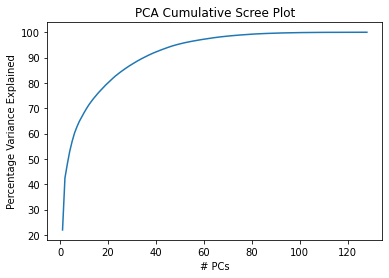

In [52]:
# PCA

pca = PCA()
pca.fit(XScaled_t)
X_pca = pca.fit_transform(XScaled_t)

y = np.cumsum(pca.explained_variance_ratio_ * 100)
x = np.arange(1,len(pca.explained_variance_)+1)
plt.plot(x,y)
plt.ylabel('Percentage Variance Explained')
plt.xlabel('# PCs')
plt.title('PCA Cumulative Scree Plot')
plt.show()

In [53]:
np.cumsum(pca.explained_variance_ratio_)


array([0.21959475, 0.4244254 , 0.47990852, 0.52999495, 0.56916002,
       0.60195222, 0.62667051, 0.64803869, 0.6656666 , 0.6827277 ,
       0.69871605, 0.71368818, 0.72675549, 0.73902935, 0.75058348,
       0.76151962, 0.77178174, 0.78195438, 0.79166004, 0.80070061,
       0.80955487, 0.81830266, 0.82677669, 0.83431806, 0.84162817,
       0.84860367, 0.85524372, 0.86169384, 0.86800758, 0.87389785,
       0.87963913, 0.88522799, 0.89055922, 0.89567436, 0.9005398 ,
       0.90535998, 0.90990382, 0.91425796, 0.91847277, 0.9223725 ,
       0.92616215, 0.92980433, 0.93340913, 0.93696999, 0.94024412,
       0.94342156, 0.94644604, 0.94921919, 0.95176524, 0.95416924,
       0.95653381, 0.95869462, 0.96071481, 0.96261836, 0.9644093 ,
       0.96613167, 0.96781539, 0.96947699, 0.97105388, 0.97255252,
       0.97399746, 0.97543823, 0.97683554, 0.97816783, 0.97946826,
       0.98070359, 0.98183574, 0.98289613, 0.98390717, 0.98486779,
       0.98578101, 0.98667692, 0.98748792, 0.98828979, 0.98906

In [54]:
#Escolho o número de componentes baseado na variância acumalada desejada
cumsum = np.cumsum(pca.explained_variance_ratio_)

d = np.argmax(cumsum >= 0.9) + 1
d

35

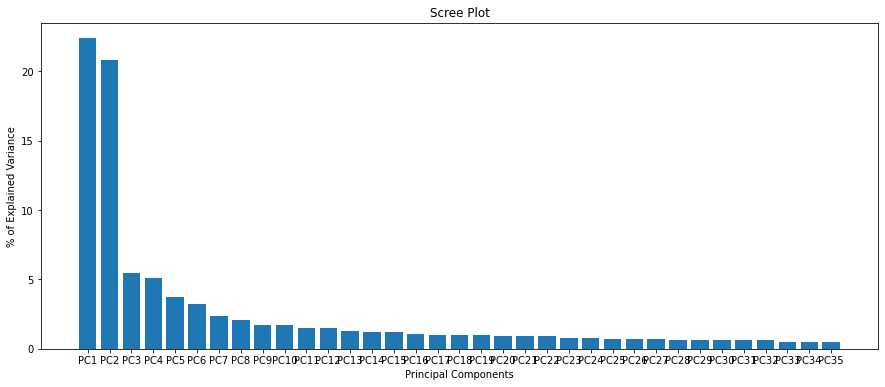

In [60]:
pca = PCA(n_components=d)
pca.fit(X_train_t)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

X_train_pca = pca.transform(X_train_t)
X_test_pca = pca.transform(X_test_t)
# pca_df = pd.DataFrame(data = X_pca, columns=labels)
# pca_df['winner'] = df_t['winner']

plt.figure(figsize = (15, 6))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('% of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

avg_avg_degree_centrality_T1_1H        -0.174144
avg_avg_degree_centrality_T1_2H        -0.174002
avg_avg_closeness_centrality_T1_2H     -0.173914
avg_avg_closeness_centrality_T1_1H     -0.173403
avg_avg_betweenness_centrality_T1_1H    0.173110
avg_avg_betweenness_centrality_T1_2H    0.171720
avg_avg_shortest_path_T1_1H             0.171562
avg_min_clustering_T1_2H               -0.171238
avg_ball_possession_T1                 -0.169128
avg_min_clustering_T1_1H               -0.168679
dtype: float64


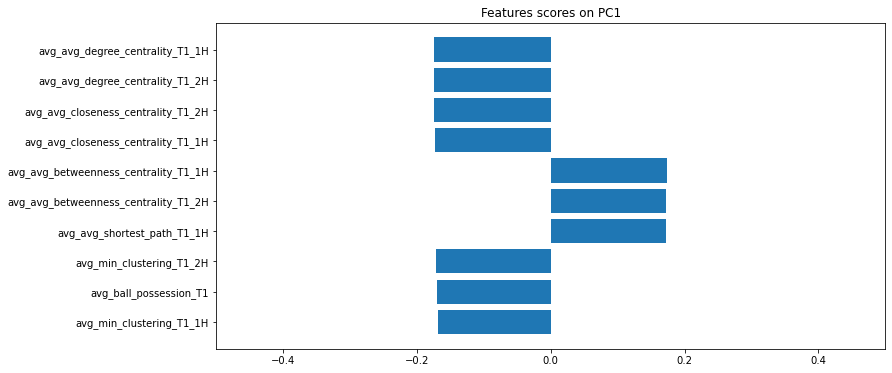

In [56]:
## get the name of the top 10 measurements that contribute most to pc1.
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=X_t.columns)
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 features
top_10_features = sorted_loading_scores[:10].index.values
 
print(loading_scores[top_10_features])

plt.figure(figsize = (12, 6))
plt.xlim([-0.5, 0.5])
plt.barh(top_10_features[::-1], loading_scores[top_10_features][::-1])
plt.title('Features scores on PC1')
plt.show()

In [64]:
pca = PCA()
pca.fit(XScaled)
X_pca = pca.fit_transform(XScaled)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.9) + 1
print(d)

pca = PCA(n_components=d)
pca.fit(X_train)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

25
